# Pre-Paid Card Marketing (Card Company)

## Data Preprocessing

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import loguniform, randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, classification_report, f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

import utils

In [4]:
df = pd.read_csv('../data/Financial Wellness Data.csv')
df

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
0,10350,2,3,5,5,6,55,3,3,3,...,1,4,8,0,0,0,0,1,0,0.367292
1,7740,1,3,6,6,6,51,2,2,3,...,1,2,3,0,0,0,0,2,0,1.327561
2,13699,1,3,4,3,4,49,3,3,3,...,1,4,9,0,0,0,1,2,1,0.835156
3,7267,1,3,6,6,6,49,3,3,3,...,1,3,7,0,0,0,0,1,0,1.410871
4,7375,1,3,4,4,4,49,3,3,3,...,1,2,4,0,0,1,0,4,1,4.260668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,11220,3,3,6,7,7,61,3,3,1,...,1,2,3,0,0,0,1,2,-5,0.522504
6390,13118,3,2,7,7,7,59,3,4,2,...,1,3,6,0,0,0,0,3,-5,1.015219
6391,8709,1,3,5,6,6,59,3,4,3,...,1,1,2,0,0,0,0,2,0,1.136270
6392,8515,1,3,5,5,5,46,2,2,3,...,1,4,9,0,0,0,0,2,0,1.224941


In [5]:
# find duplicates
df[df.duplicated()]

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt


In [6]:
# check for missing values
df.isnull().sum()

PUF_ID         0
sample         0
fpl            0
SWB_1          0
SWB_2          0
              ..
PPT612         0
PPT1317        0
PPT18OV        0
PCTLT200FPL    0
finalwt        0
Length: 217, dtype: int64

In [7]:
# check the data types
df.dtypes

PUF_ID           int64
sample           int64
fpl              int64
SWB_1            int64
SWB_2            int64
                ...   
PPT612           int64
PPT1317          int64
PPT18OV          int64
PCTLT200FPL      int64
finalwt        float64
Length: 217, dtype: object

In [8]:
# check if any features have zero variance
df.var() == 0

PUF_ID         False
sample         False
fpl            False
SWB_1          False
SWB_2          False
               ...  
PPT612         False
PPT1317        False
PPT18OV        False
PCTLT200FPL    False
finalwt        False
Length: 217, dtype: bool

## Exploratory Data Analysis

In [9]:
# Describe the data
df.describe()

,PUF_ID,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,...,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL,finalwt
count,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,...,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000,6394.000000
mean,10892.392712,1.279794,2.658899,5.353769,5.362215,5.432280,56.034094,3.048014,3.191899,2.531279,...,0.866124,2.644823,5.145605,0.035815,0.078511,0.129653,0.122928,2.084298,-0.081952,1.000000
std,1967.854493,0.570187,0.656944,1.500913,1.544942,1.613876,14.154676,1.235221,1.114130,1.196235,...,0.340545,1.032583,2.529397,0.185843,0.268995,0.335947,0.328380,0.814345,1.328498,0.585406
min,7123.000000,1.000000,1.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,-4.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-5.000000,0.165567
25%,9235.250000,1.000000,3.000000,5.000000,5.000000,5.000000,48.000000,2.000000,3.000000,2.000000,...,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.600582
50%,10901.500000,1.000000,3.000000,6.000000,6.000000,6.000000,56.000000,3.000000,3.000000,2.000000,...,1.000000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.845213
75%,12570.750000,1.000000,3.000000,6.000000,7.000000,7.000000,65.000000,4.000000,4.000000,3.000000,...,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.251415
max,14400.000000,3.000000,3.000000,7.000000,7.000000,7.000000,95.000000,5.000000,5.000000,5.000000,...,1.000000,4.000000,9.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,6.638674


## Feature Engineering

In [10]:
# Split the data into features and target
X = df.drop(columns=['PUF_ID', 'PRODUSE_3'])
y = df['PRODUSE_3']

In [11]:
# drop some variables
X = X.drop(columns=['finalwt', 'PRODUSE_6'])
X

,sample,fpl,SWB_1,SWB_2,SWB_3,FWBscore,FWB1_1,FWB1_2,FWB1_3,FWB1_4,...,PPMARIT,PPMSACAT,PPREG4,PPREG9,PPT01,PPT25,PPT612,PPT1317,PPT18OV,PCTLT200FPL
0,2,3,5,5,6,55,3,3,3,3,...,3,1,4,8,0,0,0,0,1,0
1,1,3,6,6,6,51,2,2,3,3,...,3,1,2,3,0,0,0,0,2,0
2,1,3,4,3,4,49,3,3,3,3,...,3,1,4,9,0,0,0,1,2,1
3,1,3,6,6,6,49,3,3,3,3,...,3,1,3,7,0,0,0,0,1,0
4,1,3,4,4,4,49,3,3,3,3,...,1,1,2,4,0,0,1,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,3,3,6,7,7,61,3,3,1,3,...,1,1,2,3,0,0,0,1,2,-5
6390,3,2,7,7,7,59,3,4,2,4,...,1,1,3,6,0,0,0,0,3,-5
6391,1,3,5,6,6,59,3,4,3,3,...,1,1,1,2,0,0,0,0,2,0
6392,1,3,5,5,5,46,2,2,3,2,...,5,1,4,9,0,0,0,0,2,0


<Axes: xlabel='PRODUSE_3'>

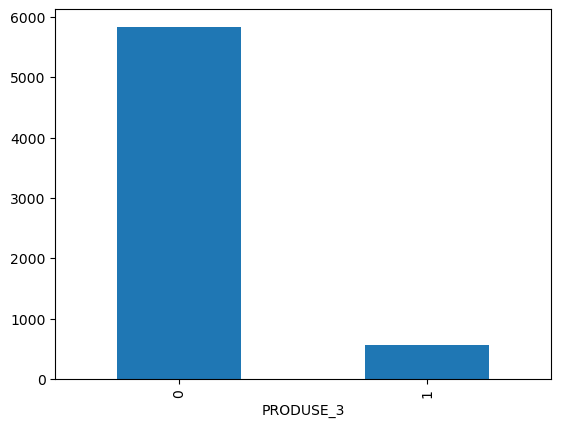

In [12]:
# plot the distribution of the target variable
y.value_counts().plot(kind='bar')

### Dummify the categorical variables

In [13]:
# dummify any integer columns
df_categorical = X.astype('object')

# dummify the categorical variables
X = pd.get_dummies(df_categorical, drop_first=True)
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,True,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,False,False,False,True,False,False,False,False,True,False,...,True,False,False,False,True,True,False,False,False,True
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,True,False,False,False,False,True,False,...,False,False,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,False,True,False,True,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False
6390,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6391,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,True,False
6392,False,False,False,True,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,True,False


In [14]:
# convert the one-hot encoded data to integers
X = X.astype('float64')
X

,sample_2,sample_3,fpl_2,fpl_3,SWB_1_-1,SWB_1_1,SWB_1_2,SWB_1_3,SWB_1_4,SWB_1_5,...,PPREG9_9,PPT01_1,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_2,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0,PCTLT200FPL_1
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6391,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6392,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


### Remove Highly Correlated Features

In [15]:
# remove columns with high multicollinearity
X_vif = utils.calculate_vif(X, correlation_threshold=0.85, variance_threshold=0.05)
X_vif

Removed highly correlated variables: ['EARNERS_2', 'MATHARDSHIP_6_2', 'BENEFITS_2_1', 'SNAP_1', 'MATHARDSHIP_5_2', 'PAIDHELP_0', 'EMPLOY1_2_1', 'FINSOC2_5_1', 'ON1correct_1', 'FK3correct_1', 'KH1correct_1', 'KHKNOWL6_2', 'FINSOC2_1_1', 'REJECTED_2_1', 'KH7correct_1', 'BENEFITS_4_1', 'KH8correct_1', 'FK1correct_1', 'KH5correct_1', 'BENEFITS_1_1', 'PCTLT200FPL_1', 'EMPLOY1_8_1', 'SOCSEC2_-2', 'FINSOC2_7_1', 'KH4correct_1', 'REJECTED_1_1', 'BENEFITS_5_1', 'MILITARY_1', 'KH2correct_1', 'FINSOC2_6_1', 'FK2correct_1', 'KH9correct_1', 'DISCOUNT_2', 'Military_Status_5', 'BENEFITS_3_1', 'EMPLOY1_4_1', 'KHKNOWL4_2', 'FINSOC2_4_1', 'FINSOC2_3_1', 'KHKNOWL5_2', 'FINSOC2_2_1', 'MEMLOSS_1', 'BORROW_1_1', 'KHKNOWL9_2', 'FINGOALS_1', 'KH3correct_1', 'CONSPROTECT3_1', 'BORROW_2_1', 'EMPLOY1_3_1', 'SOCSEC3_-2', 'KH6correct_1', 'FINKNOWL3_2']


Removed variable: PPREG4_4 with VIF: 303483905881195.50
Removed variable: FWB2_2_3 with VIF: 3286.93
Removed variable: LMscore_3 with VIF: 2024.04
Removed variable: FWB1_4_3 with VIF: 1321.79
Removed variable: FWB2_1_2 with VIF: 1109.24
Removed variable: MANAGE1_3_5 with VIF: 556.76
Removed variable: FWB1_5_3 with VIF: 512.32
Removed variable: FWB2_4_3 with VIF: 419.39
Removed variable: FWB1_1_3 with VIF: 347.08
Removed variable: FS1_5_3 with VIF: 276.68
Removed variable: FWB1_2_3 with VIF: 262.27
Removed variable: KHKNOWL1_3 with VIF: 245.82
Removed variable: KHscore_0.712 with VIF: 222.08
Removed variable: FINKNOWL2_3 with VIF: 211.52
Removed variable: SOCSEC1_1 with VIF: 140.23
Removed variable: KIDS_4_0 with VIF: 121.51
Removed variable: KHKNOWL2_3 with VIF: 118.16
Removed variable: HOUSING_1 with VIF: 89.80
Removed variable: DISTRESS_3 with VIF: 73.04
Removed variable: KHKNOWL8_2 with VIF: 72.38
Removed variable: OUTLOOK_1_4 with VIF: 71.71
Removed variable: FRAUD2_0 with VIF: 70.

,sample_2,sample_3,fpl_2,SWB_1_4,SWB_1_5,SWB_1_6,SWB_2_4,SWB_2_5,SWB_2_6,SWB_2_7,...,PPREG9_5,PPREG9_7,PPREG9_8,PPREG9_9,PPT25_1,PPT612_1,PPT1317_1,PPT18OV_3,PPT18OV_4,PCTLT200FPL_0
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6389,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6390,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6391,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6392,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Split the Data

In [16]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.2, stratify=y, random_state=42)

### Logistic Regression to Find Important Features

In [17]:
X_train_const = sm.add_constant(X_train)

logit_model_reg = sm.Logit(y_train, X_train_const).fit_regularized(method='l1', alpha=1)
print(logit_model_reg.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2301615715542186
            Iterations: 402
            Function evaluations: 403
            Gradient evaluations: 402
                           Logit Regression Results                           
Dep. Variable:              PRODUSE_3   No. Observations:                 5115
Model:                          Logit   Df Residuals:                     4767
Method:                           MLE   Df Model:                          347
Date:                Sun, 10 Nov 2024   Pseudo R-squ.:                  0.2622
Time:                        17:46:26   Log-Likelihood:                -1120.5
converged:                       True   LL-Null:                       -1518.7
Covariance Type:            nonrobust   LLR p-value:                 2.322e-37
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

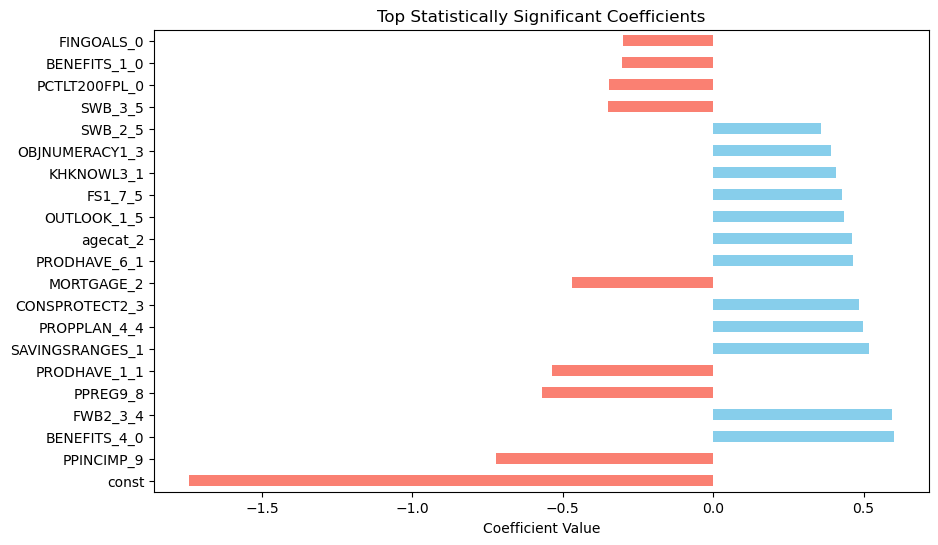

In [46]:
# Get the coefficients and p-values
coefficients = logit_model_reg.params
p_values = logit_model_reg.pvalues

# Create a DataFrame to hold coefficients and p-values for easier processing
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-Value': p_values
})

# Filter out statistically significant coefficients (e.g., p-value < 0.05)
significant_coefs = coef_df[coef_df['P-Value'] < 0.05]

# Sort coefficients by absolute value (to find the top 20 largest), keeping the sign
top_coefs = significant_coefs['Coefficient'].abs().sort_values(ascending=False).head(21).index

# Filter the original coefficients DataFrame to get the top 20 largest coefficients (with signs)
top_coefs_with_signs = significant_coefs.loc[top_coefs]

# Plot the top 20 largest coefficients with their signs
plt.figure(figsize=(10, 6))
top_coefs_with_signs['Coefficient'].plot(kind='barh', color=['skyblue' if coeff >= 0 else 'salmon' for coeff in
                                                             top_coefs_with_signs['Coefficient']])
plt.xlabel('Coefficient Value')
plt.title('Top Statistically Significant Coefficients')
plt.show()

In [ ]:
# take the top coefficients and create a new dataframe
top_features = top_coefs_with_signs.index

# drop the constant column
top_features = top_features.drop('const')

In [47]:
top_features = top_features.drop(['FINGOALS_0', 'BENEFITS_1_0', 'SWB_3_5', 'SWB_2_5'])

X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# reset the index
X_train_top.reset_index(drop=True, inplace=True)
X_test_top.reset_index(drop=True, inplace=True)
X_train_top

,PPINCIMP_9,BENEFITS_4_0,FWB2_3_4,PPREG9_8,PRODHAVE_1_1,SAVINGSRANGES_1,PROPPLAN_4_4,CONSPROTECT2_3,MORTGAGE_2,PRODHAVE_6_1,agecat_2,OUTLOOK_1_5,FS1_7_5,KHKNOWL3_1,OBJNUMERACY1_3,SWB_2_5,SWB_3_5,PCTLT200FPL_0,BENEFITS_1_0,FINGOALS_0
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5111,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5112,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5113,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Model Building

### Scoring and Cross-Validation

In [48]:
# Define a custom scorer
scorer = make_scorer(f1_score)

In [49]:
# Create a stratified k-fold object to ensure class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Logistic Regression

In [50]:
# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_top, y_train)

LogisticRegression(random_state=42)

In [51]:
# evaluate the model with default hyperparameters
y_pred_lr = lr_model.predict(X_test_top)

In [52]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_lr = {
    'penalty': [None],  # Regularization type
    'C': loguniform(1e-4, 1e4),  # Regularization strength (inverse of alpha)
    'solver': ['liblinear', 'saga', 'lbfgs'],  # Solver options
    #'l1_ratio': [0.1, 0.5, 0.9],  # ElasticNet mixing (only for 'elasticnet' penalty)
    'max_iter': randint(100, 5000)  # Max iterations
}


#### RandomizedSearchCV

In [53]:
# Perform GridSearchCV
# Create a GridSearchCV object
logit_random_search = RandomizedSearchCV(
    estimator=lr_model,
    param_distributions=param_dist_lr,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

logit_random_search.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/garrinshieh/anaconda3/envs/FINA4390/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio par

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x34a727650>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x3169d4550>,
                                        'penalty': [None],
                                        'solver': ['liblinear', 'saga',
                                                   'lbfgs']},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [54]:
# Print the best parameters and score
print("Best Parameters: ", logit_random_search.best_params_)
print("Best Score: ", logit_random_search.best_score_)

Best Parameters:  {'C': 0.09915644566638401, 'max_iter': 960, 'penalty': None, 'solver': 'lbfgs'}
Best Score:  0.05000554262276909


In [55]:
# evaluate the model with the best hyperparameters
y_pred_lr_hyper = logit_random_search.predict(X_test_top)

#### Classification Report

In [56]:
# Print the classification report
print(classification_report(y_test, y_pred_lr_hyper))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1167
           1       0.43      0.03      0.05       112

    accuracy                           0.91      1279
   macro avg       0.67      0.51      0.50      1279
weighted avg       0.87      0.91      0.87      1279



#### Threshold Optimization

In [57]:
# Find the optimal threshold
y_prob = logit_random_search.predict_proba(X_test_top)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Choose a threshold based on the desired balance of precision and recall
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Optimal threshold for best F1-score: {best_threshold}")

Optimal threshold for best F1-score: 0.10388448044504278


In [58]:
# Evaluate the model with the optimal threshold
y_pred_lr_optimal = (y_prob >= best_threshold).astype(int)

# Print the classification report
print(classification_report(y_test, y_pred_lr_optimal))

              precision    recall  f1-score   support

           0       0.95      0.73      0.82      1167
           1       0.17      0.56      0.26       112

    accuracy                           0.72      1279
   macro avg       0.56      0.65      0.54      1279
weighted avg       0.88      0.72      0.77      1279



### Random Forest

In [59]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_top, y_train)

RandomForestClassifier(random_state=42)

In [60]:
# evaluate the model with default hyperparameters
y_pred_rf = rf_model.predict(X_test_top)

In [61]:
# Define the parameter distribution for RandomizedSearchCV
param_dist_rf = {
    'n_estimators': randint(200, 1200),  # Number of trees in the forest
    'max_depth': randint(5, 15),  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'class_weight': ['balanced', 'balanced_subsample', None]  # Weights associated with classes
}

#### RandomizedSearchCV

In [62]:
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_rf,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random_search.fit(X_train_top, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34a725b50>,
                                        'max_features'...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x322399350>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34b095d50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34e9e8bd0>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [63]:
# Print the best parameters and score
print("Best Parameters: ", rf_random_search.best_params_)
print("Best Score: ", rf_random_search.best_score_)

Best Parameters:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 462}
Best Score:  0.28344217692911083


In [64]:
# evaluate the model with the best hyperparameters
y_pred_rf_hyper = rf_random_search.predict(X_test_top)

#### Classification Report

In [65]:
# Print the classification report
print(classification_report(y_test, y_pred_rf_hyper))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83      1167
           1       0.14      0.43      0.22       112

    accuracy                           0.73      1279
   macro avg       0.54      0.59      0.52      1279
weighted avg       0.86      0.73      0.78      1279



### XGBoost

In [66]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_top, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [67]:
# evaluate the model with default hyperparameters
y_pred_xgb = xgb_model.predict(X_test_top)

In [68]:
# Define the parameter distribution for GridSearchCV
param_distributions_xgb = {
    'n_estimators': randint(50, 1000),  # Number of boosting rounds
    'learning_rate': uniform(0.01, 0.5),  # Step size shrinkage
    'max_depth': randint(3, 10),  # Maximum depth of a tree
    'min_child_weight': randint(1, 6),  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': uniform(0, 1),  # Minimum loss reduction to make a split
    'subsample': uniform(0.1, 0.9),  # Subsample ratio of the training data
    'colsample_bytree': uniform(0.1, 0.9),  # Subsample ratio of columns when constructing each tree
    'scale_pos_weight': randint(1, 10),  # Controls the balance of positive and negative classes
}

#### RandomizedSearchCV

In [69]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=100,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

xgb_random_search.fit(X_train_top, y_train, verbose=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=0.09915644566638401, max_iter=960, penalty=None, solver=lbfgs; total time=   0.0s
[CV] END C=0.00014610865886287216, max_iter=869, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.004997040685255816, max_iter=1284, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.0023130924416844114, max_iter=2535, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=0.0023130924416844114, max_iter=2535, penalty=None, solver=liblinear; total time=   0.0s
[CV] END C=5309.5322690092235, max_iter=341, penalty=None, solver=saga; total time=   0.0s
[CV] END C=5309.5322690092235, max_iter=341, penalty=None, solver=saga; total time=   0.0s
[CV] END C=462.9768693362657, max_iter=134, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.13442649050633507, max_iter=1685, penalty=None, solver=saga; total time=   0.0s
[CV] END C=0.13442649050633507, max_iter=1685, penalty=None, solver=saga; total time=   0.

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importan...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34ea44210>,
                                        'scale_pos_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x34ebbe450>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x34ea89c50>},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'),
                   verbose=2)

#### Best Parameters and Best Score

In [70]:
# Print the best parameters and score
print("Best Parameters: ", xgb_random_search.best_params_)
print("Best Score: ", xgb_random_search.best_score_)

Best Parameters:  {'colsample_bytree': 0.14633087612499043, 'gamma': 0.27864646423661144, 'learning_rate': 0.46413294298332686, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 102, 'scale_pos_weight': 6, 'subsample': 0.3178497443603504}
Best Score:  0.285212016665505


In [71]:
# evaluate the model with the best hyperparameters
y_pred_xgb_hyper = xgb_random_search.predict(X_test_top)

#### Classification Report

In [72]:
# Print the classification report
print(classification_report(y_test, y_pred_xgb_hyper))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1167
           1       0.17      0.38      0.24       112

    accuracy                           0.78      1279
   macro avg       0.55      0.60      0.55      1279
weighted avg       0.87      0.78      0.82      1279



## Results

In [73]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
predictions_base = [y_pred_lr, y_pred_rf, y_pred_xgb]
predictions_hyper = [y_pred_lr_hyper, y_pred_rf_hyper, y_pred_xgb_hyper]

results = utils.evaluate_models(models=models, predictions_base=predictions_base, predictions_hyper=predictions_hyper,
                                X=X_test_top, y_test=y_test)
results

,,Logistic Regression,Random Forest,XGBoost,Best Model,Best Value
Metric,Type,,,,,
Accuracy,Base,0.912432,0.899922,0.899922,Logistic Regression,0.912432
Precision,Base,0.5,0.214286,0.25,Logistic Regression,0.500000
Recall,Base,0.026786,0.053571,0.071429,Random Forest,0.428571
F1 Score,Base,0.050847,0.085714,0.111111,XGBoost,0.235616
Positive Precision,Base,0.5,0.214286,0.25,Logistic Regression,0.500000
Negative Precision,Base,0.914375,0.915268,0.9166,XGBoost,0.932749
Positive Recall,Base,0.026786,0.053571,0.071429,Random Forest,0.428571
Negative Recall,Base,0.997429,0.981148,0.979434,Logistic Regression,0.997429
Positive F1 Score,Base,0.050847,0.085714,0.111111,XGBoost,0.235616
